In [1]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output
import sys

In [2]:
transform = lambda img: np.array(np.asarray(img).flatten())/256
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5672336.94it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 471172.78it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1387485.31it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2419421.99it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

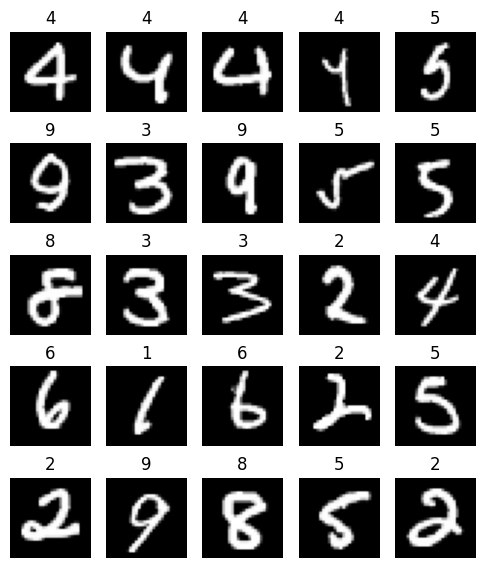

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### 1. Реализовать на языке высокого уровня многослойный персептрон и проверить его работоспособность на примере данных, выбранных из MNIST dataset. 

In [5]:
from tqdm import tqdm
def train(network,train_loader, test_loader, epochs, learning_rate, plot=True,
          verbose=True, loss=None, optimizer='GD'):
    loss = loss or MSELoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    grad_pre = None
    b = 0
    try:
        for epoch in tqdm(range(epochs)):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                
                if optimizer=='GD':
                    dLdx = dLdx
                elif optimizer=='FR':
                    if grad_pre is None:
                        grad_pre = dLdx
                    else:
                        dLdx_flat = dLdx.flatten()
                        grad_pre_flat = grad_pre.flatten()
                        b = (np.sum(dLdx_flat*dLdx_flat)/np.sum(grad_pre_flat*grad_pre_flat))**2
                        b = max(min(b, 1), 0)
                    grad_pre = dLdx
                    dLdx = (dLdx + b*grad_pre)
                
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) Loss: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [6]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass
    
def softmax(z):
    exp = np.exp(z - np.max(z))
    
    for i in range(len(z)):
        exp[i] /= np.sum(exp[i])
        
    return exp

class Softmax:
    def __init__(self):
        pass

    def forward(self, inputs):
        self.inputs = inputs
        return softmax(inputs)

    def backward(self, dLdy):
        return dLdy
    
    def step(self, learning_rate):
        pass

In [7]:
class CELoss:
    def __init__(self):
        pass
    
    def forward(self, X, y):
        self.p = np.exp(X - np.max(X, axis=1, keepdims=True))
        self.p /= self.p.sum(axis=1, keepdims=True)
    
        self.y = np.zeros((X.shape[0], X.shape[1]))
        self.y[np.arange(X.shape[0]), y] = 1
        
        return -np.mean(np.sum(self.y * np.log(self.p + 1e-15), axis=1))
    
    def backward(self):
        return (self.p - self.y) / self.y.shape[0]
    
class MSELoss:
    def __init__(self):
        pass
    
    def forward(self, X, y):
        self.X = X
        
        self.y = np.zeros((X.shape[0], X.shape[1]))
        self.y[np.arange(X.shape[0]), y] = 1

        return np.mean(np.square(self.X - self.y))
    
    def backward(self):
        return 2 * (self.X - self.y) / self.y.shape[0]
    

class KLLoss:
    def __init__(self):
        pass
    
    def forward(self, pred, target):
        self.pred = np.clip(pred, 1e-10, 1 - 1e-10)
        
        self.target = np.zeros((pred.shape[0], pred.shape[1]))
        self.target[np.arange(pred.shape[0]), target] = 1
        
        self.target = np.clip(self.target, 1e-10, 1 - 1e-10)
        
        return np.mean(self.target * np.log(self.target/self.pred))
    
    def backward(self):
        self.pred = np.clip(self.pred, 1e-8, 1 - 1e-8)
        res = self.pred - self.target
        return res / np.linalg.norm(res)

In [8]:
class Linear:
    def __init__(self, input_size, output_size):
        self.W = np.random.randn(input_size, output_size)*0.01
        self.b = np.zeros(output_size)

    def forward(self, X):
        self.X = X
        return X.dot(self.W)+self.b

    def backward(self, dLdy):
        self.dLdW = self.X.T.dot(dLdy)
        self.dLdb = dLdy.sum(0)
        self.dLdx = dLdy.dot(self.W.T)
        return self.dLdx

    def step(self, learning_rate):
        self.W = self.W - learning_rate * self.dLdW
        self.b = self.b - learning_rate * self.dLdb


class NeuralNetwork:
    def __init__(self, modules):
        self.modules = modules
    
    def forward(self, X):
        y = X
        for i in range(len(self.modules)):
            y = self.modules[i].forward(y)
        return y
    
    def backward(self, dLdy):
        for i in range(len(self.modules))[::-1]:
            dLdy = self.modules[i].backward(dLdy)
    
    def step(self, learning_rate):
        for i in range(len(self.modules)):
            self.modules[i].step(learning_rate)

### 2. Исследовать работу персептрона на основе использования различных целевых функций. (среднеквадратичная ошибка, перекрестная энтропия, дивергенция Кульбака-Лейблера).

Epoch 9... (Train/Test) Loss: 0.010/0.010	Accuracy: 0.957/0.958

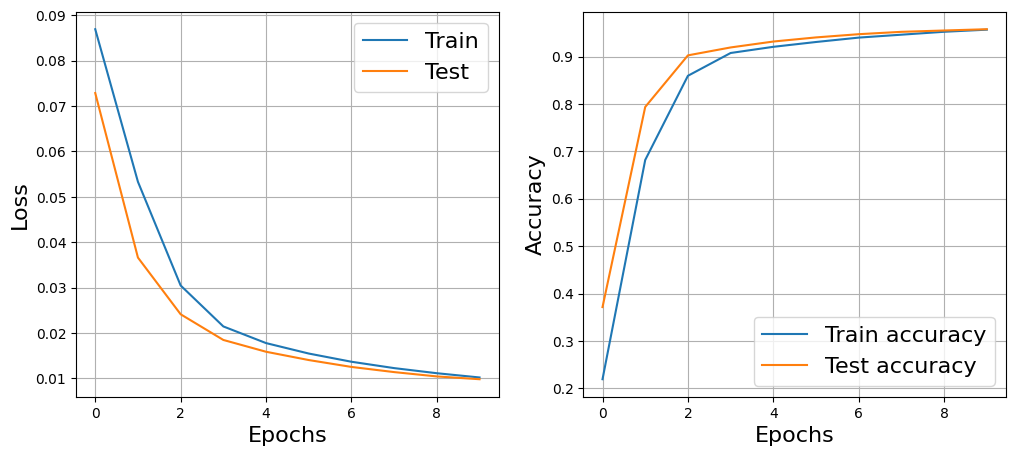

100%|██████████| 10/10 [03:02<00:00, 18.23s/it]


In [42]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = MSELoss()
tr_mse_gd, ts_mse_gd, tr_ac_mse_gd, ts_ac_mse_gd = train(
    network,train_loader,test_loader, 10, 0.01, plot=True, verbose=True, loss=loss, optimizer='GD')

Epoch 9... (Train/Test) Loss: 0.217/0.204	Accuracy: 0.938/0.939

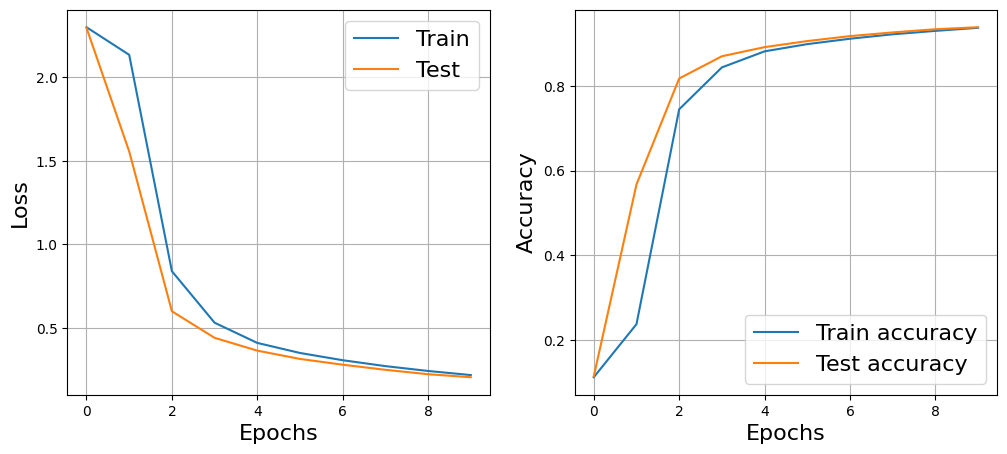

100%|██████████| 10/10 [03:01<00:00, 18.17s/it]


In [43]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = CELoss()
tr_ce_gd, ts_ce_gd, tr_ac_ce_gd, ts_ac_ce_gd = train(
    network,train_loader,test_loader, 10, 0.01, plot=True, verbose=True,loss=loss,optimizer='GD')

Epoch 9... (Train/Test) Loss: 0.058/0.222	Accuracy: 0.947/0.903

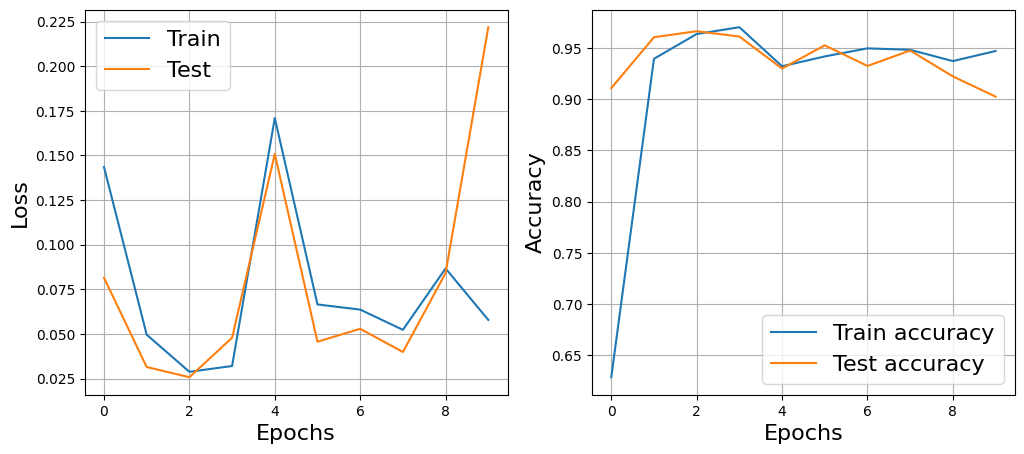

100%|██████████| 10/10 [03:04<00:00, 18.42s/it]


In [44]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = KLLoss()
tr_kll_gd, ts_kll_gd, tr_ac_kll_gd, ts_ac_kll_gd = train(
    network,train_loader,test_loader, 10, 0.01, plot=True, verbose=True, loss=loss,optimizer='GD')

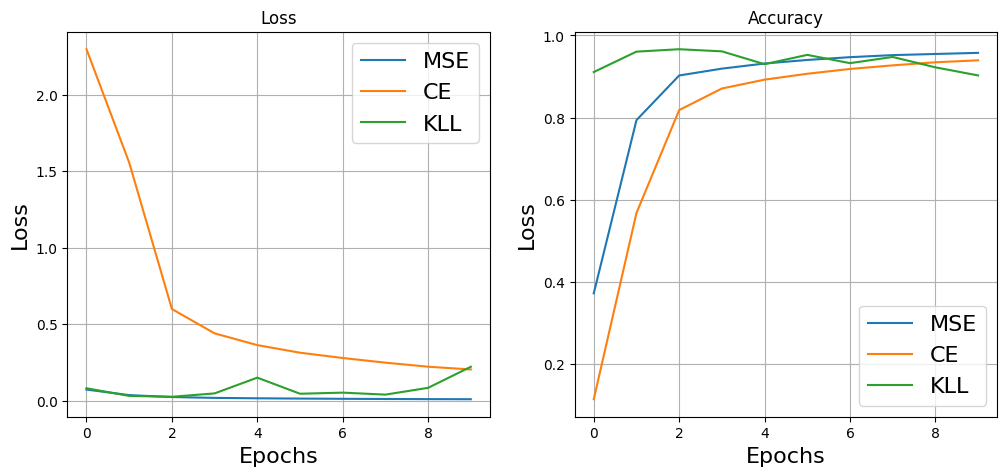

In [45]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_mse_gd, label='MSE')
plt.plot(ts_ce_gd, label='CE')
plt.plot(ts_kll_gd, label='KLL')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_mse_gd, label='MSE')
plt.plot(ts_ac_ce_gd, label='CE')
plt.plot(ts_ac_kll_gd, label='KLL')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### 3. Исследовать работу многослойного персептрона с использованием различных методов оптимизации (градиентный, Флетчера-Ривза (FR)).

Epoch 9... (Train/Test) Loss: 0.010/0.009	Accuracy: 0.960/0.961

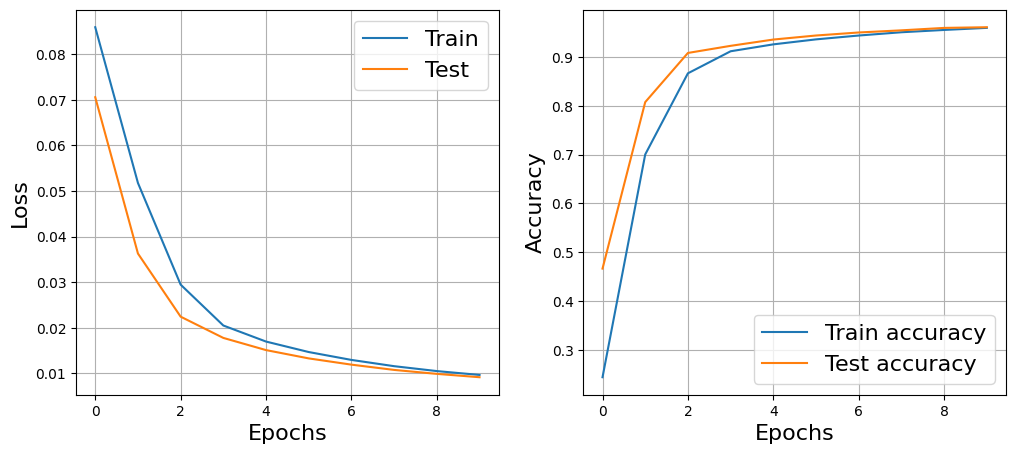

100%|██████████| 10/10 [02:09<00:00, 12.99s/it]


In [11]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = MSELoss()
tr_mse_gd, ts_mse_gd, tr_ac_mse_gd, ts_ac_mse_gd = train(
    network,train_loader,test_loader, 10, 0.01, plot=True, verbose=True, loss=loss, optimizer='GD')

Epoch 9... (Train/Test) Loss: 0.007/0.007	Accuracy: 0.974/0.972

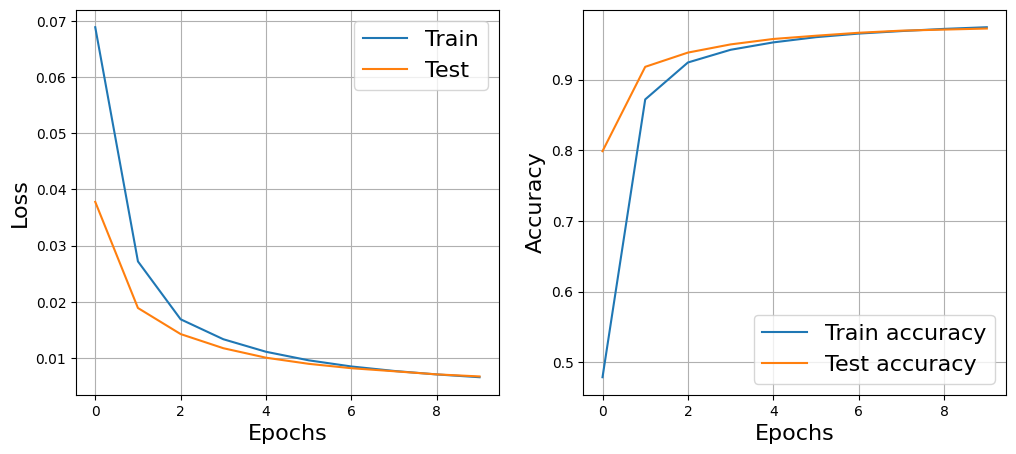

100%|██████████| 10/10 [02:10<00:00, 13.08s/it]


In [12]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = MSELoss()
tr_mse_fr, ts_mse_fr, tr_ac_mse_fr, ts_ac_mse_fr = train(
    network,train_loader,test_loader, 10, 0.01, plot=True, verbose=True, loss=loss, optimizer='FR')

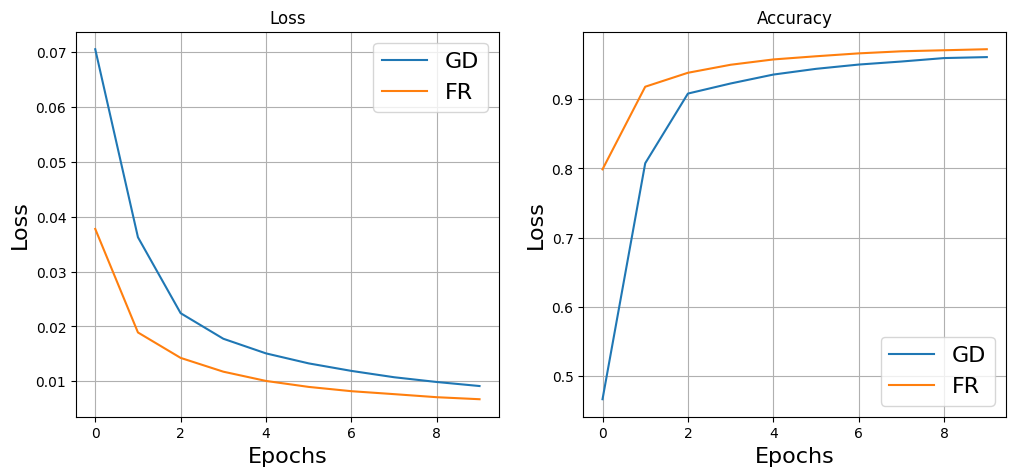

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_mse_gd, label='GD')
plt.plot(ts_mse_fr, label='FR')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_mse_gd, label='GD')
plt.plot(ts_ac_mse_fr, label='FR')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### 4. Провести исследование эффективности работы многослойного персептрона при изменении гиперпараметров (количества нейронов и количества слоев).

Epoch 9... (Train/Test) Loss: 0.005/0.005	Accuracy: 0.969/0.966

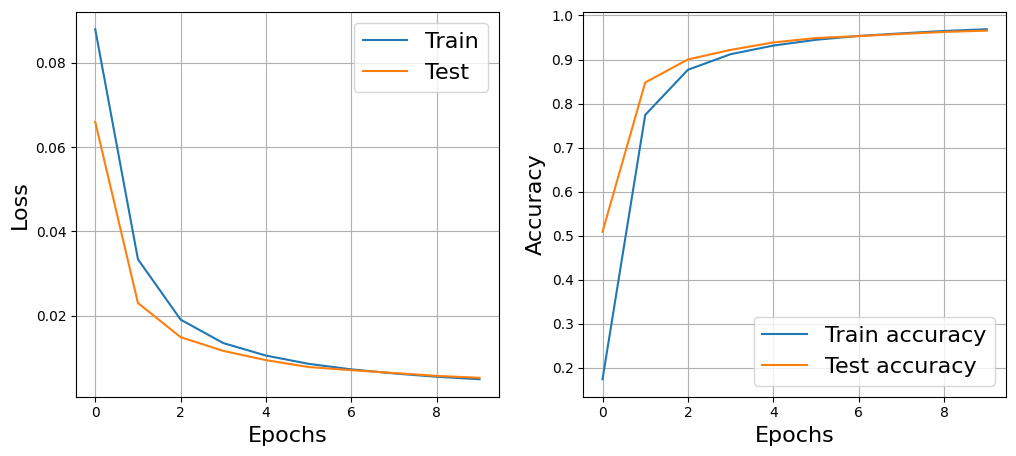

100%|██████████| 10/10 [02:21<00:00, 14.11s/it]


In [35]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10), Softmax()
])
loss = MSELoss()
tr_mse_fr1, ts_mse_fr1, tr_ac_mse_fr1, ts_ac_mse_fr1 = train(
    network,train_loader,test_loader, 10, 0.01, plot=True, verbose=True, loss=loss, optimizer='GD')

Epoch 9... (Train/Test) Loss: 0.027/0.023	Accuracy: 0.873/0.891

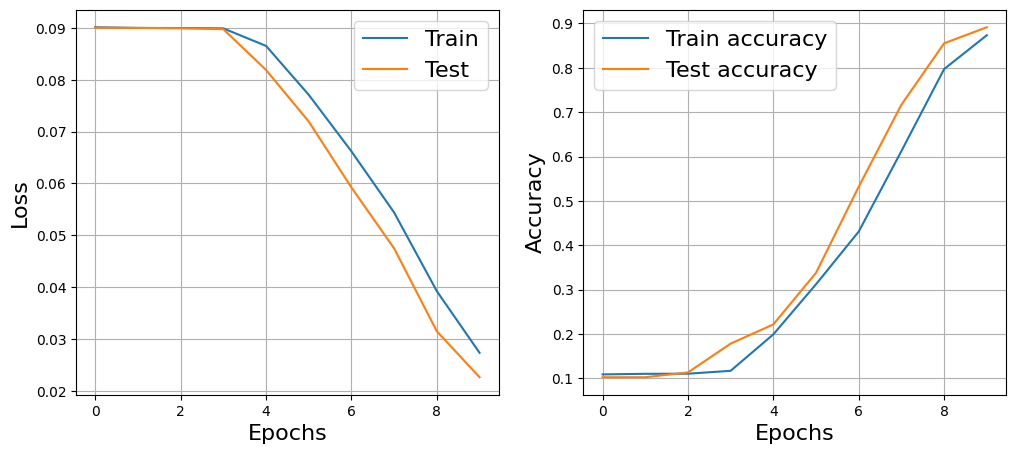

100%|██████████| 10/10 [03:50<00:00, 23.05s/it]


In [14]:
network = NeuralNetwork([
    Linear(784, 256), ReLU(),
    Linear(256, 64), ReLU(),
    Linear(64, 64), ReLU(),
    Linear(64, 10),
])
loss = MSELoss()
tr_mse_fr1, ts_mse_fr1, tr_ac_mse_fr1, ts_ac_mse_fr1 = train(
    network,train_loader,test_loader, 10, 0.01, plot=True, verbose=True, loss=loss, optimizer='GD')